# Work In Progress (WIP)



# 3. Multi-qubit gates and algorithms

In [1]:
# Specific install for Kaggle Notebooks environment
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# Kaleido is used to convert Plotly to static png
!pip install -Uqq kaleido
!pip install -Uqq skq

# skq

In previous notebooks we got an extensive overview of how to work with a single qubit. In this notebook we will generalize to multiple qubits and finally look at meaningful algorithms that quantum computing offers. The previous notebooks gave you a solid toolbox from which to construct these algorithms. From here we will focus more on applying gates to construct quantum circuits.

To avoid having to construct gates and concepts from scratch each time we will use the [skq](https://github.com/CarloLepelaars/skq) library. I built this library so you can easily play with quantum concepts (in NumPy) and build your own algorithms. These circuits can then be converted to popular quantum frameworks like [Qiskit](https://github.com/Qiskit/qiskit) and [OpenQASM](https://openqasm.com/intro.html) so you can run them on real quantum computers.

All the quantum logic gates we talked about in previous notebooks can be found in the `skq.gates.qubit` module. We will also heavily use `Concat` for multi-qubit gates and `Circuit` for quantum circuits. These are relatively simple objects, but can be extended to any complex circuit.

In [2]:
import numpy as np

from skq.gates.qubit import X, H, I, CX, CCX, SWAP, CSwap, Measure
from skq.circuits import Concat, Circuit, BellStates

import plotly.graph_objects as go

# Fix Plotly rendering in Jupyter forks.
# If you are running this notebook locally you can comment this out.
# This allows you to play with interactive Plotly plots.
import plotly.io as pio
pio.renderers.default = 'png'

## Bell State

One of the first breakthroughs for quantum computing was the discovery and application of a completely entangled state called the Bell state. In this state 2 qubits are 100% correlated to each other. This enables use cases that are not possible classically like quantum communication and quantum teleportation.

The simplest Bell State ($| \Psi^+ \rangle$) is called the Phi Plus state and is defined as follows:

$$
| \Psi^+ \rangle = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)
$$

To prepare entanglement we first initialize two qubits ($|00 \rangle = [1, 0, 0, 0]$) and put the 1st qubit in the superposition state with a Hadamard ($H$) gate. The 1st qubit is not changed in this first step so the $I$ gate is applied.



`Concat` is an object we use to concatenate gates for multiple qubits. To obtain the concatenated operation the Tensor (Kronecker) product is used.

In [3]:
step1 = Concat([H(), I()])

The result of a concatenation is not just stacking $2$ matrices, but a new matrix that is applied to a $2$-qubit state. In this case the concatenation of $2$ single qubit gates results in a $4 \times 4$ matrix. This grows exponentially with the number of qubits. For example, concatenating $3$ single qubit gates results in a $2^3 \times 2^3 = 8 \times 8$ matrix.

In [4]:
step1.encoding_matrix

H([[ 0.70710678+0.j,  0.        +0.j,  0.70710678+0.j,  0.        +0.j],
   [ 0.        +0.j,  0.70710678+0.j,  0.        +0.j,  0.70710678+0.j],
   [ 0.70710678+0.j,  0.        +0.j, -0.70710678+0.j, -0.        +0.j],
   [ 0.        +0.j,  0.70710678+0.j, -0.        +0.j, -0.70710678+0.j]])

In [5]:
output1 = step1([1, 0, 0, 0])
output1

H([0.70710678+0.j, 0.        +0.j, 0.70710678+0.j, 0.        +0.j])

We have learned that every qubit gate can also be run in reverse, so we can do the same with `Concat`.

In [6]:
step1.decodes(output1).round(8)

H([ 1.+0.j,  0.+0.j, -0.+0.j,  0.+0.j])

The two qubits are then entangled using the CNOT ($CX$) gate. This results in a fully entangled state of 2 qubits. It's important to note that we cannot think about single qubits anymore because we now have a 2-qubit state. The individual qubits cannot be visualized nicely on a Bloch sphere anymore, because the state of the qubits depend on each other. It is like flipping 2 coins at the same time, but the outcome will always be either 2 heads or 2 tails.

In [7]:
step2 = CX()
step2(step1([1, 0, 0, 0]))

array([0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j])

These qubits can be separated over large distances and can enable secure communication, among other things.

Now let's construct the complete circuit and verify that we implemented the Bell state correctly. `Circuit` is a convenient extension of `list` that will run all quantum operations in sequence. It also has functionality to convert to popular quantum frameworks like [Qiskit](https://github.com/Qiskit/qiskit) and [OpenQASM](https://openqasm.com/intro.html).

In [8]:
bell_circuit = Circuit([step1, step2])
bell_state = bell_circuit([1, 0, 0, 0])
bell_state

array([0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j])

Recall that measurement can be done by taking the absolute square of the state vector and sampling from it.

You will see that the only possible outcomes are $00$ and $11$ and they are roughly evenly distributed. On real quantum computers there is noise so there is a small chance of still measuring $01$ or $10$.

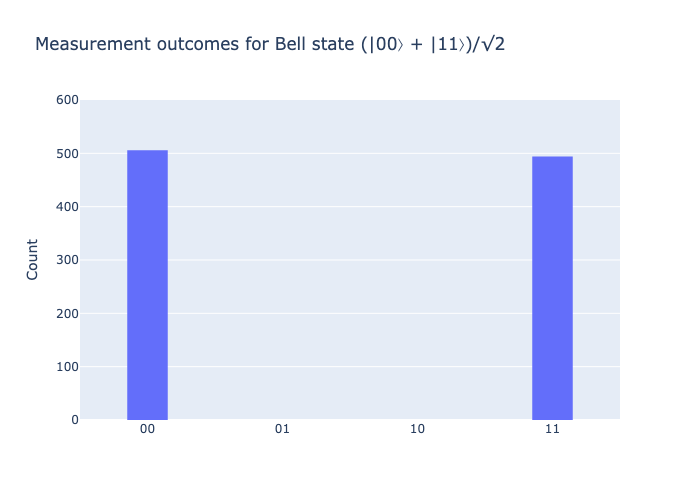

In [9]:
def measure_state(s):
    # Absolute value squared gives us the probability distribution from the statevector
    p = np.abs(s) ** 2
    # Sample from probability distribution to get classical bits
    # Only states |00⟩ and |11⟩ should have non-zero probability for Bell state
    return np.random.choice([0, 3], p=[p[0], p[3]])

# Sample the Bell state 1000 times
samples = [measure_state(bell_state) for _ in range(1000)]

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=samples,
    xbins=dict(
        start=-0.5,
        end=3.5,
        size=1
    ),
))
fig.update_layout(
    title="Measurement outcomes for Bell state (|00⟩ + |11⟩)/√2",
    xaxis=dict(
        tickmode="array",
        tickvals=[0, 1, 2, 3],  # Show all possible states
        ticktext=["00", "01", "10", "11"]
    ),
    yaxis=dict(
        title="Count",
        range=[0, 600]
    ),
    bargap=0.7  # Add some gap between bars
)
fig.show()

In `skq` we can directly intialize the Bell states as a building block in our circuits.

In [10]:
phi_plus = BellStates().get_bell_state(1)

bell_state1 = phi_plus([1,0,0,0])
assert np.allclose(bell_state, bell_state1)

We can convert to a Qiskit circuit. This Qiskit circuit can be run on a real quantum computer. Qiskit also offers visualization tools to inspect the circuit. In total there are 4 Bell states, but the behavior of the 'Plus' and 'Minus' states is the same. For simplicity the conversion will remove any Identity ($I$) gates.

In [11]:
bell = BellStates()
for i, name in enumerate(["Phi Plus (|Φ+⟩). Entangles |00⟩ and |11⟩.", 
                          "Phi Minus (|Φ-⟩). Entangles |00⟩ and |11⟩ with opposite phase.", 
                          "Psi Plus (|Ψ+⟩). Entangles |01⟩ and |10⟩.", 
                          "Psi Minus (|Ψ-⟩). Entangles |01⟩ and |10⟩ with opposite phase."], 
                          start=1):
    circuit = bell.get_bell_state(i)
    qiskit_circuit = circuit.convert(framework="qiskit")
    print(f"Bell state {i}: {name}")
    print(qiskit_circuit.draw())

Bell state 1: Phi Plus (|Φ+⟩). Entangles |00⟩ and |11⟩.
     ┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘
Bell state 2: Phi Minus (|Φ-⟩). Entangles |00⟩ and |11⟩ with opposite phase.
     ┌───┐     ┌───┐
q_0: ┤ H ├──■──┤ Z ├
     └───┘┌─┴─┐└───┘
q_1: ─────┤ X ├─────
          └───┘     
Bell state 3: Psi Plus (|Ψ+⟩). Entangles |01⟩ and |10⟩.
     ┌───┐     
q_0: ┤ H ├──■──
     ├───┤┌─┴─┐
q_1: ┤ X ├┤ X ├
     └───┘└───┘
Bell state 4: Psi Minus (|Ψ-⟩). Entangles |01⟩ and |10⟩ with opposite phase.
     ┌───┐┌───┐     
q_0: ┤ H ├┤ Z ├──■──
     ├───┤├───┤┌─┴─┐
q_1: ┤ X ├┤ Z ├┤ X ├
     └───┘└───┘└───┘


Often it will be clearer to use the [Matplotlib](https://matplotlib.org) circuit visualization to Qiskit offers. Define `output="mpl"` to use this.

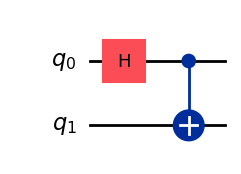

In [12]:
phi_plus.convert(framework="qiskit").draw(output="mpl")

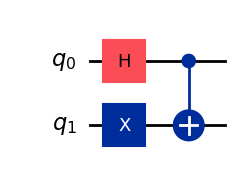

In [13]:
psi_plus = BellStates().get_bell_state(3)
psi_plus.convert(framework="qiskit").draw(output="mpl")

Another popular standard for defining quantum circuits is [OpenQASM](https://openqasm.com/intro.html). You can think of OpenQASM as a low-level assembly language for quantum computers. We will devote a separate notebook to go more in-depth into OpenQASM. For now understand that many providers of quantum computers support OpenQASM and we can convert `skq` circuits to OpenQASM. 

In [14]:
print(psi_plus.convert(framework="qasm"))

h q[0];
x q[1];
cx q[0], q[1];


By adding `Measure()` to a circuit we can add measurement to the end of the circuit. The outcome of running the circuit will be a classical bitstring.

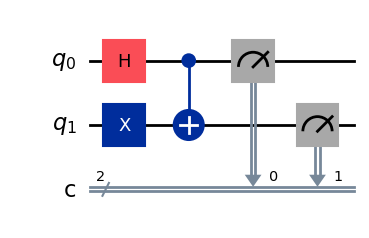

In [15]:
psi_plus_with_measure = Circuit([*psi_plus, Measure()])
psi_plus_with_measure.convert(framework="qiskit").draw(output="mpl")

In [16]:
print(psi_plus_with_measure.convert(framework="qasm"))

h q[0];
x q[1];
cx q[0], q[1];
measure q[0] -> c[0];
measure q[1] -> c[1];


## GHZ State

A GHZ State generalizes the notion of a Bell state to $n$ qubits. This creates a fully entangled state between all the qubits.

Let's for example that a 3-qubit GHZ state. It is defined as:

$$
GHZ_3 = \frac{1}{\sqrt{2}}(|000\rangle + |111\rangle)
$$



In [17]:
# TODO Show generalization of Bell state to n qubits

## Toffoli (CCX) Gate

A Toffoli ($CCX$) gate is similar to a CNOT gate, but for 3 qubits. If the 1st 2 qubits are 1, the 3rd qubit is flipped. We therefore say it has 2 control qubits. A gate for 3 qubits requires a $2^3 \times 2^3 = 8 \times 8$ matrix to represent classically. You can see why it becomes infeasible to simulate quantum circuits for many qubits on a classical computer.


$$CCX = \begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
\end{bmatrix}
$$


In [18]:
CCX()

CCX([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
     [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
     [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
     [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
     [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
     [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
     [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
     [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]])

We can construct a Toffoli gate from CNOT gates. 

In [19]:
# Construct Toffoli from CNOT gates

## SWAP

$$SWAP = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}
$$

In [20]:
SWAP()

SWAP([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
      [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
      [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
      [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

In [21]:
[0,1,0,0] @ SWAP()

SWAP([0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j])

# TODO Explain SWAP gate and significance for real (transpiled) quantum circuits

## BONUS: CSWAP

$$CSWAP = \begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
\end{bmatrix}
$$


In [22]:
CSwap()

CSwap([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

In [23]:
[0,0,0,0,0,1,0,0] @ CSwap()

CSwap([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j])

# Work In Progress (WIP)